In [1]:
import os
import sys
import inspect
import torch
import torchvision
import random
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import face_lib.models as mlib
import face_lib.datasets as dlib
import face_lib.utils as utils
# from config import training_args

In [2]:
device = torch.device("cuda:0")

In [3]:
checkpoint_path = "/gpfs/gpfs0/r.karimov/models/pfe/first_ms1m_pfe/sota.pt"
casia_dir = "/gpfs/gpfs0/r.karimov/casia"
cats_dir = "/gpfs/gpfs0/r.karimov/cats"

In [4]:
class Args():
    def __init__(self):
        self.train_file = os.path.join(casia_dir, "ldmarks.txt")
        self.casia_dir = os.path.join(casia_dir, "data_")
        self.cats_dir = os.path.join(cats_dir)
        self.try_times = 5
        self.is_debug = False
        self.in_size  = (112, 112)
        self.num_face_pb = 4
        self.in_feats = 512

args = Args()

In [5]:
checkpoint = torch.load(checkpoint_path, map_location=device)

In [6]:
model = {
    "backbone" : mlib.iresnet50(),
    "uncertain" : mlib.PFEHeadAdjustable(25088, args.in_feats)
}
model["backbone"].load_state_dict(checkpoint["backbone"])
model["uncertain"].load_state_dict(checkpoint["uncertain"])

model["backbone"] = model["backbone"].eval().to(device)
model["uncertain"] = model["uncertain"].eval().to(device)

In [8]:
cats_set = dlib.CatsDataset(args)
face_set = dlib.CASIAWebFace(args)

In [9]:
print ("Cats : ", len(cats_set))
print ("Faces : ", len(face_set))

Cats :  139958
Faces :  490871


In [10]:
slice_size = 10000
assert slice_size < min(len(cats_set), len(face_set))

cats_subset = torch.utils.data.Subset(cats_set, range(slice_size))
face_subset = torch.utils.data.Subset(face_set, range(slice_size))

In [11]:
def calculate_uncertainty(log_sig_sq):
    sq_sigmas = torch.exp(log_sig_sq)
#     uncertainty = 1 / (1 / sq_sigmas).sum(axis=1)
    uncertainty = sq_sigmas.mean(axis=1)
    return uncertainty

@torch.no_grad()
def calculate_dataset_uncertainties(model, dataset, device=torch.device("cpu")):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    
    uncertainties = []
    
    for batch, _ in tqdm(loader):
        batch = torch.tensor(batch, dtype=torch.float).to(device)
        
        feature, sig_feat = model["backbone"](batch)
        log_sig_sq = model["uncertain"](sig_feat)
        
        uncertainty = calculate_uncertainty(log_sig_sq)
        uncertainties.append(uncertainty.cpu())
    
    return torch.cat(uncertainties, dim=0)

In [12]:
cats_uncertainties = calculate_dataset_uncertainties(model, cats_subset, device=device)

  0%|          | 0/157 [00:00<?, ?it/s]/trinity/home/r.kail/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
100%|██████████| 157/157 [05:00<00:00,  1.92s/it]


In [13]:
face_uncertainties = calculate_dataset_uncertainties(model, face_subset, device=device)

  0%|          | 0/157 [00:00<?, ?it/s]/trinity/home/r.kail/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
100%|██████████| 157/157 [00:34<00:00,  4.59it/s]


In [14]:
cats_scores = np.array(cats_uncertainties)
face_scores = np.array(face_uncertainties)

cats_targets = np.ones_like(cats_scores)
face_targets = np.zeros_like(face_scores)

scores = np.concatenate((cats_scores, face_scores,), axis=0)
targets = np.concatenate((cats_targets, face_targets,), axis=0)

In [15]:
from sklearn.metrics import roc_curve, auc

In [16]:
fpr, tpr, thresholds = roc_curve(targets, scores)
roc_auc = auc(fpr, tpr)

/trinity/home/r.kail/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


ROC_AUC :  0.8435632599999999


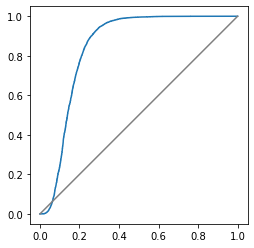

In [17]:
plt.plot(fpr, tpr)
plt.plot((0, 1), (0, 1), c="grey")
plt.axes().set_aspect('equal')
                      
print ("ROC_AUC : ", roc_auc)